# IoT Device Classification
**Research Question**  
Which machine learning model best classifies IOT device network activity? Can probability thresholds be used to detect the presence of unknown IoT device network activity?

**Original Data Source**  
[Machine-Learning-for-Cybersecurity-Cookbook/Chapter05
/IoT Device Type Identification Using Machine Learning](https://github.com/PacktPublishing/Machine-Learning-for-Cybersecurity-Cookbook/tree/master/Chapter05/IoT%20Device%20Type%20Identification%20Using%20Machine%20Learning)

**Description**  
Identifying IOT network connection activity (security cameras, thermostats, etc.) is relevant for network security. Some network devices have logs or applications allowing you to view device connections, but sometimes meaningful information about the device type is missing. The goal of this machine learning project is to classify IoT network connections as their recognized IoT device type and to investigate if probability thresholds can be used to classify samples not trained on the model as an "unknown" connection. The ability to identify IoT connections in this way can be used alert the user and scrutinize IoT network activity.

**Machine Learning Concepts**  
Decision Tree, Logistic Regression, Random Forest, XGBoost, Neural Network and ensemble techniques will be compared to find the highest performing model.

**Expected Results**  
Various machine learning models will be trained and results analyzed and compared. Probability distributions will be examined to determine if a threshold value exists to distinguish between unknown and trained IoT devices.


# Imports

In [75]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import time

from scipy.stats import gaussian_kde
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from sklearn.feature_selection import VarianceThreshold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, multilabel_confusion_matrix, accuracy_score, recall_score, precision_score, f1_score, average_precision_score, precision_recall_curve
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.multiclass import OneVsRestClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, StandardScaler
from tensorflow.keras.callbacks import EarlyStopping
from xgboost import XGBClassifier

# Constants and Global Declarations


In [76]:
random_state = 42

baseline_model_name = 'One-Vs-Rest (Baseline)'
neural_network_model_name = 'Neural Network'
ovr_model_name = 'One-Vs-Rest'
random_forest_model_name = 'Random Forest'
xgboost_model_name = 'XGBoost'

selected_models = {}

# result positions for get_<model>_predictions()
y_pred_classes_result = 0
y_pred_proba_result = 1
class_labels_result = 2

# Functions and Methods

## EDA

### Data Exploration

In [77]:
'''
Get the names of columns containing only a single value.
This method is used to identify columns that can be removed from the dataset because they do not contain any useful information.
'''
def get_single_valued_columns(dataframe):
  single_valued_columns = []
  for column_name in dataframe.columns:
    if len(dataframe[column_name].value_counts()) == 1:
      single_valued_columns.append(column_name)

  return single_valued_columns

In [78]:
'''
Get the names of columns containing only 0 and 1 for the specified data type.
This method is used to identify columns that should not be scaled.
'''
def get_binary_column_names(dataframe, data_type):
  binary_column_names = []
  for column_name in dataframe.columns:
    if dataframe[column_name].dtype == data_type:
      if set(X_train[column_name].unique()) <= {0, 1}:
        binary_column_names.append(column_name)

  return binary_column_names

### Feature Analysis

In [79]:
'''
Get the coefficients of the LASSO model.
'''
def get_lasso_coefficients(composite_classifier, X_train):
  estimators = composite_classifier.estimators_
  categories = composite_classifier.classes_
  feature_names = X_train.columns.values

  coef_dict = {}
  for i in range(len(estimators)):
    coefs = estimators[i].coef_.flatten()
    category = categories[i]
    coef_dict[category] = coefs

  coef_df = pd.DataFrame(coef_dict, index=feature_names)
  return coef_df

## Machine Learning Models

In [80]:
def get_onevsrest_predictions(ovr_model, X):
  ovr_y_pred_classes = ovr_model.predict(X)
  ovr_y_pred_proba = ovr_model.predict_proba(X)
  ovr_class_labels = ovr_model.classes_

  return (ovr_y_pred_classes, ovr_y_pred_proba, ovr_class_labels)

In [81]:
def get_randomforest_predictions(rf_model, X_val):
  rf_y_pred_classes = rf_model.predict(X_val)
  rf_y_pred_proba = rf_model.predict_proba(X_val)
  rf_class_labels = rf_model.classes_

  return (rf_y_pred_classes, rf_y_pred_proba, rf_class_labels)

In [82]:
def get_xgboost_predictions(xgb_model, X, xgb_label_encoder):

  # xgboost predict returnes class indexes and not class names
  # inverse_transforms recovers the class names from the indexes
  xgb_y_pred_class_indexes = xgb_model.predict(X)
  xgb_y_pred_classes = xgb_label_encoder.inverse_transform(xgb_y_pred_class_indexes)
  xgb_y_pred_proba = xgb_model.predict_proba(X)
  xgb_class_labels = xgb_label_encoder.classes_

  return (xgb_y_pred_classes, xgb_y_pred_proba, xgb_class_labels)

In [83]:
def get_softmax_predictions(nn_model, X, nn_label_encoder):
  # predict() for this neural network returns softmax values similar to predict_proba() from a scikit-learn estimator
  nn_y_pred_proba = nn_model.predict(X)

  nn_y_pred_class_indexes = np.argmax(nn_y_pred_proba, axis=1)
  nn_y_pred_classes = nn_label_encoder.inverse_transform(nn_y_pred_class_indexes)
  nn_class_labels = nn_label_encoder.classes_

  return (nn_y_pred_classes, nn_y_pred_proba, nn_class_labels)

In [84]:
def to_dictionary(predictions_tuple):
  predictions_dictionary = {}
  predictions_dictionary[y_pred_classes_result] = predictions_tuple[y_pred_classes_result]
  predictions_dictionary[y_pred_proba_result] = predictions_tuple[y_pred_proba_result]
  predictions_dictionary[class_labels_result] = predictions_tuple[class_labels_result]

  return predictions_dictionary

In [85]:
def get_all_model_predictions(X, xgb_label_encoder, nn_label_encoder, preprocessing_pipeline):

  ## use the scikit learn preprocessing pipeline to scale the input data the
  X_scaled = preprocessing_pipeline.transform(X)

  predictions_dictionary = {
    baseline_model_name: to_dictionary(get_onevsrest_predictions(selected_models[baseline_model_name], X)),
    ovr_model_name: to_dictionary(get_onevsrest_predictions(selected_models[ovr_model_name], X)),
    random_forest_model_name: to_dictionary(get_randomforest_predictions(selected_models[random_forest_model_name], X)),
    xgboost_model_name: to_dictionary(get_xgboost_predictions(selected_models[xgboost_model_name], X, xgb_label_encoder)),
    neural_network_model_name: to_dictionary(get_softmax_predictions(selected_models[neural_network_model_name], X_scaled, nn_label_encoder))
  }

  return predictions_dictionary

## Model Metric Calculations

In [86]:
def get_accuracy_score_per_threshold_value(y_actual, y_pred_probs, class_labels, thresholds = np.linspace(0.0, 0.95, 20)):
  accuracy_scores = []
  for threshold in thresholds:

    threshold_predictions = []
    for class_probabilities in y_pred_probs:
      max_prob = np.max(class_probabilities)
      if max_prob < threshold:
        threshold_predictions.append('unknown')
      else:
        threshold_predictions.append(class_labels[np.argmax(class_probabilities)])

    threshold_accuracy_score = accuracy_score(y_actual, threshold_predictions)
    accuracy_scores.append(threshold_accuracy_score)

  # 1..n thresholds, 1..n accuracy scores
  return (thresholds, accuracy_scores)

In [87]:
def get_threshold_metric_scores(metric, y_actual, y_pred_proba, class_labels, thresholds):
  scores = []
  for threshold in thresholds:

    y_pred = []
    for class_probabilities in y_pred_proba:
      max_prob = np.max(class_probabilities)
      if max_prob < threshold:
        y_pred.append('unknown')
      else:
        y_pred.append(class_labels[np.argmax(class_probabilities)])

    if metric == "accuracy":
      scores.append(accuracy_score(y_actual, y_pred))
    elif metric == "f1":
      scores.append(f1_score(y_actual, y_pred, average='macro'))
    elif metric == "precision":
      scores.append(precision_score(y_actual, y_pred, average='macro'))
    elif metric == "recall":
      scores.append(recall_score(y_actual, y_pred, average="weighted", zero_division=0))
    else:
      raise ValueError("Invalid metric function. Use 'accuracy', 'recall', or 'f1'")

  return (thresholds, scores)

In [88]:
def get_threshold_metric_scores_for_models(metric, model_dictionary, y_actual, class_labels, thresholds = np.linspace(0.0, 0.95, 20)):
  score_dict = {}
  for model_name, y_pred_proba in model_dictionary.items():
    (_, scores) = get_threshold_metric_scores(metric, y_actual, y_pred_proba, class_labels, thresholds)
    score_dict[model_name] = scores

  return (thresholds, score_dict)

In [89]:
def get_metrics_report(all_model_predictions, y_actual, class_labels):

  y_pred_classes = {}
  for model_name, predictions_dictionary in all_model_predictions.items():
    y_pred_classes[model_name] = predictions_dictionary[y_pred_classes_result]

  metrics_report = {}
  for model_name, y_pred in y_pred_classes.items():

    accuracy = accuracy_score(y_actual, y_pred)
    precision = precision_score(y_actual, y_pred, average="macro")
    recall = recall_score(y_actual, y_pred, average="macro", zero_division=0)
    f1 = f1_score(y_actual, y_pred, average='macro')

    metrics_report[model_name] = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

  return metrics_report

In [90]:
def print_metrics_report(metrics_report):

  print("| Model | Accuracy | Precision | Recall | f1 |")
  print("|---|---|---|---|---|")

  for model_name, metrics in metrics_report.items():
    acc = "{:.3f}".format(metrics['accuracy'])
    prec = "{:.3f}".format(metrics['precision'])
    rec = "{:.3f}".format(metrics['recall'])
    f1 = "{:.3f}".format(metrics['f1'])

    print(f"| {model_name} | {acc} | {prec} | {rec} | {f1} |")

## Calculations

In [91]:
'''
return values:
all: all probability values from predict_proba()
successful: probability values from predict_proba() for successful predictions
unsuccessful: probability values from predict_proba() for failed predictions
'''
def get_probabilities(model_name, y_actual, y_pred, y_predict_proba):
  all_probabilities = y_predict_proba.max(axis=1)

  successful_predictions = y_pred == y_actual
  successful_prediction_probabilies = y_predict_proba[successful_predictions].max(axis=1)

  unsucessful_prediction_probabilies = y_predict_proba[~successful_predictions].max(axis=1)

  return (all_probabilities, successful_prediction_probabilies, unsucessful_prediction_probabilies)

## Graphing and Plots

### Single Model Plots

In [92]:
def add_confusion_matrix_to_display(axis, y_actual, y_pred, class_labels):
  cm = confusion_matrix(y_actual, y_pred)

  display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
  display.plot(ax=axis, cmap='Blues')
  plt.setp(axis.get_xticklabels(), rotation=45, ha="right")
  axis.set_title("Confusion Matrix")

In [93]:
def add_accuracy_plot_to_display(axis, model_name, thresholds, accuracy_scores):

  axis.plot(thresholds, accuracy_scores, marker='o', linestyle='-', label=model_name)

  axis.set(
      xlabel='Decision Threshold',
      ylabel='Accuracy',
      title=f'Accuracy vs. Decision Threshold'
  )

  axis.grid(True)
  axis.legend()

In [94]:
def add_f1_plot_to_display(axis, model_name, thresholds, f1_scores):

  axis.plot(thresholds, f1_scores, marker='o', linestyle='-', label=model_name)

  axis.set(
      xlabel='Decision Threshold',
      ylabel='f1',
      title=f'f1 vs. Decision Threshold'
  )

  axis.grid(True)
  axis.legend()

In [95]:
def add_probability_density_plot_to_display(axis, model_name, all_probabilities, successful_probabilities, unsuccessful_probabilities):
  kde_all = gaussian_kde(all_probabilities)
  kde_successful = gaussian_kde(successful_probabilities)
  kde_unsuccessful = gaussian_kde(unsuccessful_probabilities)

  # Define evaluation points (support)
  x = np.linspace(0, 1, 1000)

  density_all = kde_all(x)
  density_successful = kde_successful(x)
  density_unsuccessful = kde_unsuccessful(x)

  axis.plot(x, density_all, label='All Predictions')
  axis.plot(x, density_successful, label='Successful Predictions')
  axis.plot(x, density_unsuccessful, label='Unsuccessful Predictions')
  axis.set_xlabel('Probability')
  axis.set_ylabel('Density')
  axis.set_title(f'Probability Density')
  axis.legend()

In [96]:
def create_classification_model_display(model_name, y_actual, y_pred_class, y_pred_probs, class_labels):
  fig, axes = plt.subplots(1, 4, figsize=(15, 4)) # rows, columns, (width, height)

  # confusion matrix
  add_confusion_matrix_to_display( axes[0], y_actual, y_pred_class, class_labels)

  # accuracy plot
  (thresholds, accuracy_scores) = get_accuracy_score_per_threshold_value(y_actual, y_pred_probs, class_labels)
  add_accuracy_plot_to_display(axes[1], model_name, thresholds, accuracy_scores)

  # f1 plot
  # (thresholds, accuracy_scores) = get_accuracy_score_per_threshold_value(y_actual, y_pred_probs, class_labels)
  (_, f1_scores) = get_threshold_metric_scores("f1", y_actual, y_pred_probs, class_labels, thresholds)
  add_f1_plot_to_display(axes[2], model_name, thresholds, accuracy_scores)

  # probability plot
  (all_probabilities, successful_probabilities, unsuccessful_probabilities) = get_probabilities(model_name, y_actual, y_pred_class, y_pred_probs)
  add_probability_density_plot_to_display(axes[3], model_name, all_probabilities, successful_probabilities, unsuccessful_probabilities)

  fig.subplots_adjust(top=0.85)
  fig.suptitle(f'{model_name}\n', fontsize=12)
  plt.show()

  print(classification_report(y_actual, y_pred_class, labels=class_labels))

In [97]:
def create_probability_density_plot(model_name, all_probabilities, successful_probabilities, unsuccessful_probabilities):
  kde_all = gaussian_kde(all_probabilities)
  kde_successful = gaussian_kde(successful_probabilities)
  kde_unsuccessful = gaussian_kde(unsuccessful_probabilities)

  # Define evaluation points (support)
  x = np.linspace(0, 1, 1000)

  density_all = kde_all(x)
  density_successful = kde_successful(x)
  density_unsuccessful = kde_unsuccessful(x)

  plt.plot(x, density_all, label='All Predictions')
  plt.plot(x, density_successful, label='Successful Predictions')
  plt.plot(x, density_unsuccessful, label='Unsuccessful Predictions')
  plt.xlabel('Probability')
  plt.ylabel('Density')
  plt.title(f'Probability Density: {model_name}')
  plt.legend()
  plt.show()

### Multiple Model Plots

#### Metrics


In [98]:
def plot_model_scores(thresholds, model_dictionary, title='', xlabel='', ylabel='', fig_size=(5,3)):
  plt.figure(figsize=fig_size)

  for model_name, scores in model_dictionary.items():
    plt.plot(thresholds, scores, marker='o', linestyle='-', label=model_name)

  plt.title(title)
  plt.xlabel(xlabel)
  plt.ylabel(ylabel)
  plt.grid(True)
  plt.legend()
  plt.tight_layout()
  plt.show()

In [99]:
# accuracy_metrics_dictionary: model_name -> accuracy_scores
def add_accuracy_metrics_to_display(axis, accuracy_metrics_dictionary, thresholds):
  for model_name, accuracy_scores in accuracy_metrics_dictionary.items():
    axis.plot(thresholds, accuracy_scores, marker='o', linestyle='-', label=model_name)

  axis.set(
      xlabel='Decision Threshold',
      ylabel='Accuracy',
      title=f'Accuracy vs. Decision Threshold'
  )

  axis.grid(True)
  axis.legend()

In [100]:
# f1_metrics_dictionary: model_name -> f1_scores
def add_f1_metrics_to_display(axis, f1_metrics_dictionary, thresholds):
  for model_name, f1_scores in f1_metrics_dictionary.items():
    axis.plot(thresholds, f1_scores, marker='o', linestyle='-', label=model_name)

  axis.set(
      xlabel='Decision Threshold',
      ylabel='f1',
      title=f'f1 vs. Decision Threshold'
  )

  axis.grid(True)
  axis.legend()

In [101]:
# def add_f1_plot_to_display(axis, f1_metrics_dictionary, thresholds):
#   for model_name, f1_scores in f1_metrics_dictionary.items():
#     axis.plot(thresholds, f1_scores, marker='o', linestyle='-', label=model_name)

#   axis.set(
#       xlabel='Decision Threshold',
#       ylabel='f1',
#       title=f'f1 vs. Decision Threshold'
#   )

#   axis.grid(True)
#   axis.legend()

In [102]:
# model_dictionary: model_name -> y_proba
def create_composite_metrics_display(model_dictionary, y_actual, class_labels, title = "Model Metrics"):
  fig, axes = plt.subplots(1, 2, figsize=(15, 3)) # rows, columns, (width, height)

  # accuracy metrics
  (thresholds, accuracy_metrics_dictionary) = get_threshold_metric_scores_for_models("accuracy", model_dictionary, y_actual, class_labels)
  add_accuracy_metrics_to_display(axes[0], accuracy_metrics_dictionary, thresholds)

  # f1 metrics
  (thresholds, f1_metrics_dictionary) = get_threshold_metric_scores_for_models("f1", model_dictionary, y_actual, class_labels)
  add_f1_metrics_to_display(axes[1], f1_metrics_dictionary, thresholds)

  fig.subplots_adjust(top=0.85)
  fig.suptitle(f'{title}', fontsize=12)
  plt.show()

In [103]:
def create_composite_metrics_display2(all_model_predictions, y_actual, class_labels, title = "Model Metrics"):
  fig, axes = plt.subplots(1, 2, figsize=(15, 3)) # rows, columns, (width, height)

  y_pred_proba_dictionary = {}

  for model_name, predictions_dictionary in all_model_predictions.items():
    y_pred_proba_dictionary[model_name] = predictions_dictionary[y_pred_proba_result]

  # accuracy metrics
  (thresholds, accuracy_metrics_dictionary) = get_threshold_metric_scores_for_models("accuracy", y_pred_proba_dictionary, y_actual, class_labels)
  add_accuracy_metrics_to_display(axes[0], accuracy_metrics_dictionary, thresholds)

  # f1 metrics
  (thresholds, f1_metrics_dictionary) = get_threshold_metric_scores_for_models("f1", y_pred_proba_dictionary, y_actual, class_labels)
  add_f1_metrics_to_display(axes[1], f1_metrics_dictionary, thresholds)

  fig.subplots_adjust(top=0.85)
  fig.suptitle(f'{title}', fontsize=12)
  plt.show()

#### Probabilities

In [104]:
# model_dictionary: model_name -> (y_pred_classes, y_pred_probs)
# def add_density_plots_to_display(axis, models_dictionary, all_probabilities, successful_probabilities, unsuccessful_probabilities):
def add_density_plots_to_display(axis, model_results_dictionary, y_actual, prediction_type, display_legend = True):

  x = np.linspace(0, 1, 1000)
  for model_name, predictions_dictionary in model_results_dictionary.items():
    y_pred_classes = predictions_dictionary[y_pred_classes_result]
    y_pred_probs = predictions_dictionary[y_pred_proba_result]
    (all_probabilities, successful_probabilies, unsuccessful_probabilies) = get_probabilities(model_name, y_actual, y_pred_classes, y_pred_probs)

    if prediction_type == 'Successful':
      kde = gaussian_kde(successful_probabilies)
    elif prediction_type == 'Unsuccessful':
      kde = gaussian_kde(unsuccessful_probabilies)
    else:
      kde = gaussian_kde(all_probabilities)

    density = kde(x)
    axis.plot(x, density, label=model_name)

  axis.set_xlabel('Probability')
  axis.set_ylabel('Density')
  axis.set_title(f'{prediction_type} Predictions')

  if display_legend:
    axis.legend()

In [105]:
def create_composite_probabilities_display(model_results_dictionary, y_actual, title = "Distribution of Prediction Probability Values"):
  fig, axes = plt.subplots(1, 3, figsize=(15, 3)) # rows, columns, (width, height)

  add_density_plots_to_display(axes[0], model_results_dictionary, y_actual, "All")
  add_density_plots_to_display(axes[1], model_results_dictionary, y_actual, "Successful", display_legend=False)
  add_density_plots_to_display(axes[2], model_results_dictionary, y_actual, "Unsuccessful", display_legend=False)

  fig.subplots_adjust(top=0.85)
  fig.suptitle(f'{title}', fontsize=12)
  plt.show()

## Pipelines


In [106]:
def get_preprocessing_pipeline(X_train):
  # remove low variance features and perform scaling on numeric features, then perform LASSO
  numeric_pipeline = Pipeline([
    ('variance_filter', VarianceThreshold(threshold=0.0)),
    ('scaler', StandardScaler())
])

  binary_columns = get_binary_column_names(X_train, 'int64')
  numeric_columns = X_train.columns.difference(binary_columns)

  # Create column transformer with both
  preprocessing = ColumnTransformer([
      ('numeric', numeric_pipeline, numeric_columns),
      ('binary', 'passthrough', binary_columns)
  ])

  # Final pipeline
  pipeline = Pipeline([
    ('preprocessing', preprocessing)
  ])

  return pipeline

In [107]:
'''
Creates a pipeline for a given classifier.
The preprocessing_pipeline performs variance threshold actions (removes features that only have one value) and scales numeric values.
'''
def get_pipeline(classifier, X_train):

  preprocessing_pipeline = get_preprocessing_pipeline(X_train)

  full_pipeline = Pipeline(preprocessing_pipeline.steps + [('classifier', classifier)])

  return full_pipeline

# Data

## Loading Datasets
The original dataset is already divided into training and test, but for this project, the training and test dataset will be merged and redivided into training validation and testing sets using a 60/20/20 split.

In [108]:
# Loading Datasets from Google Drive
# from google.colab import drive
# drive.mount('/content/drive')

# gd_data_path = '/content/drive/MyDrive/UCB/Assignments/Capstone/data/'
# train_csv = 'iot_devices_train.csv'
# test_csv = 'iot_devices_test.csv'

# original_train_df = pd.read_csv(gd_data_path + train_csv)
# original_test_df = pd.read_csv(gd_data_path + test_csv)

# print(f'Original Train Data Shape: {original_train_df.shape}')
# print(f'Original Test Data Shape: {original_test_df.shape}')

In [109]:
# Loading Datasets from git
original_train_url = 'https://raw.githubusercontent.com/stevetanasse/UCBML/refs/heads/main/Capstone/data/iot_devices_train.csv'
original_test_url = 'https://raw.githubusercontent.com/stevetanasse/UCBML/refs/heads/main/Capstone/data/iot_devices_test.csv'

original_train_df = pd.read_csv(original_train_url)
original_test_df = pd.read_csv(original_test_url)

print(f'Original Train Data Shape: {original_train_df.shape}')
print(f'Original Test Data Shape: {original_test_df.shape}')

Original Train Data Shape: (1000, 298)
Original Test Data Shape: (900, 298)


In [110]:
merged_df = pd.concat([original_train_df, original_test_df])
X_merged = merged_df.drop(columns=['device_category'])
y_merged = merged_df['device_category']

print(f'X_merged Data Shape: {X_merged.shape}')
print(f'y_merged Data Shape: {y_merged.shape}')

X_merged Data Shape: (1900, 297)
y_merged Data Shape: (1900,)


In [111]:
# Train/Val vs. Test (e.g., 80% train/val, 20% test)
X_temp, X_test, y_temp, y_test = train_test_split(
    X_merged, y_merged, test_size=0.2, stratify=y_merged, random_state=42
)

# Train vs. Validation (e.g., 75% train, 25% val from the 80%)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.25, stratify=y_temp, random_state=42
)

print(f'Train Data Shape: {X_train.shape}')
print(f'Validation Data Shape: {X_val.shape}')
print(f'Test Data Shape: {X_test.shape}')
print()
print('Train/Validation/Test Split Proportions:')
print(f'Train Data: {X_train.shape[0]/merged_df.shape[0]}')
print(f'Validation Data Shape: {X_val.shape[0]/merged_df.shape[0]}')
print(f'Test Data Shape: {X_test.shape[0]/merged_df.shape[0]}')

Train Data Shape: (1140, 297)
Validation Data Shape: (380, 297)
Test Data Shape: (380, 297)

Train/Validation/Test Split Proportions:
Train Data: 0.6
Validation Data Shape: 0.2
Test Data Shape: 0.2


In [112]:
y_merged.sample(5)

,device_category
910,socket
845,watch
906,socket
815,watch
387,security_camera


## Exploratory Data Analysis (EDA)
The dataset doesn't contain any null values. However, 45 columns contain only 1 value, therefore aren't meaningful and can be removed. There are 92 columns of the int64 datatype that contain binary data (0 and 1) and should not be scaled. There aren't any float64 columns containing binary data. There are 10 classes in the dataset in identical proportions with the exception of `water_sensor` which has half as many samples as the other classes.

In [113]:
X_train.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
ack,1140.0,329.079825,5.717907e+03,0.0,0.0,9.0,14.00,184378.0
ack_A,1140.0,111.612281,1.414350e+03,0.0,0.0,5.0,7.00,39265.0
ack_B,1140.0,217.786842,4.394742e+03,0.0,0.0,5.0,8.00,145113.0
bytes,1140.0,233942.723684,6.370251e+06,120.0,240.0,1213.0,2411.00,213714584.0
bytes_A,1140.0,224083.642105,6.284679e+06,0.0,0.0,743.0,1150.25,210863813.0
...,...,...,...,...,...,...,...,...
suffix_is_empty_char_value,1140.0,0.316667,4.653804e-01,0.0,0.0,0.0,1.00,1.0
suffix_is_googleapis.com,1140.0,0.000000,0.000000e+00,0.0,0.0,0.0,0.00,0.0
suffix_is_net,1140.0,0.000000,0.000000e+00,0.0,0.0,0.0,0.00,0.0
suffix_is_org,1140.0,0.000000,0.000000e+00,0.0,0.0,0.0,0.00,0.0


In [114]:
X_train.dtypes.value_counts()

,count
int64,174
float64,123


In [115]:
y_train.value_counts()

,count
device_category,
security_camera,120
socket,120
smoke_detector,120
baby_monitor,120
watch,120
lights,120
motion_sensor,120
TV,120
thermostat,120


In [116]:
# sum all of the null/nan values across all columns
X_train.isnull().sum().sum()

np.int64(0)

In [117]:
# get count of columns containing only a single value
len(get_single_valued_columns(X_train))

45

In [118]:
int64_binary_columns = get_binary_column_names(X_train, 'int64')
len(int64_binary_columns)

92

In [119]:
float64_binary_columns = get_binary_column_names(X_train, 'float64')
len(float64_binary_columns)

0

## Feature Analysis
A OneVsRestClassifier was used to perform LASSO regression to identify the relevant features associated with a class. The light, socket and water_sensor IoT devices are each associated with a small (less than 20) set of features.  Other classes are identified by feature counts between 27 and 57.

In [120]:
# construct a pipeline to perform LASSO
# remove low variance features and perform scaling on numeric features, then perform LASSO
numeric_pipeline = Pipeline([
    ('variance_filter', VarianceThreshold(threshold=0.0)),
    ('scaler', StandardScaler())
])

binary_columns = get_binary_column_names(X_train, 'int64')
numeric_columns = X_train.columns.difference(binary_columns)

# Create column transformer with both
preprocessing = ColumnTransformer([
    ('numeric', numeric_pipeline, numeric_columns),
    ('binary', 'passthrough', binary_columns)
])

# Final pipeline
lasso_lr = LogisticRegression(penalty='l1', solver='liblinear', C=1.0)
feature_analysis_pipeline = Pipeline([
    ('preprocessing', preprocessing),
    ('classifier', OneVsRestClassifier(lasso_lr))
])

In [121]:
feature_analysis_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('variance_filter',
                                                                   VarianceThreshold()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['ack', 'ack_A', 'ack_B', 'bytes', 'bytes_A', 'bytes_A_B_ratio',
       'bytes_B', 'ds_field_B', 'duration', 'http_bytes_avg',
       ...
       'ttl_avg', 'ttl_entropy', 'ttl_firstQ', 'ttl_max', 'ttl_median',
       'ttl_min'...
                                                   'ssl_count_server_ciphersuite',
                                                   'ssl_count_server_compression',
                                                   'ssl_count_server_elliptic_curve',
                                                   'ssl_count_server_name',
                                                   'ssl_count_transactions',
                                                   'ssl_count_version',
                                                   'ssl_handshake_duration_entropy',
                                                   'ssl_handshake_duration_stdev',
                                                   'ssl_handshake_duration_var', ...])])),
                ('classifier',
                 OneVsRestClassifier(estimator=LogisticRegression(penalty='l1',
                                                                  solver='liblinear')))])

In [122]:
# get the lasso coefficients for each class
lasso_coeff_df = get_lasso_coefficients(feature_analysis_pipeline['classifier'], X_train)
non_zero_column_counts = (lasso_coeff_df != 0).sum()
non_zero_column_counts.sort_values(ascending=False)

,0
TV,59
baby_monitor,54
security_camera,44
watch,42
thermostat,40
motion_sensor,36
smoke_detector,27
water_sensor,18
socket,13
lights,8


# Machine Learning Models
The machine learning models investigated for classifying IoT devices are OneVsRestClassifier, RandomForest, XGBoost, and Neural Network. The pipeline use to train and predict the classifiers is returned by the `get_pipeline()` method. The pipeline removes features that only have one value, scales numeric features and does not scale binary features.

Each machine learning model is evaluated for accuracy and f1 score. The distribution of the maximum value of predict_proba() is charted to investigate if it is feasible to use probability scores as a source of confidence. Distributions of all predictions, successful predictions and unsuccessful predictions are displayed to examine prediction patterns.

All machine learning models were challenged by identifying lights, socket, and water_sensor IoT devices. The neural network used SMOTE oversampling and it didn't create any improvement. According to LASSO analysis, the lights, socket, and water_sensor IoT classes were classes that had the least number of features distinguishing them.

## OneVsRestClassifier (Baseline)
Create a OneVsRestClassifier classifier using Logistic Regression with default settings to establish baseline performace for a machine learning model.

In [123]:
logistic_regression = LogisticRegression(class_weight='balanced', random_state=random_state, max_iter=1000)
ovr_classifier = OneVsRestClassifier(logistic_regression)
baseline_pipeline = get_pipeline(ovr_classifier, X_train)

In [124]:
baseline_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('variance_filter',
                                                                   VarianceThreshold()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['ack', 'ack_A', 'ack_B', 'bytes', 'bytes_A', 'bytes_A_B_ratio',
       'bytes_B', 'ds_field_B', 'duration', 'http_bytes_avg',
       ...
       'ttl_avg', 'ttl_entropy', 'ttl_firstQ', 'ttl_max', 'ttl_median',
       'ttl_min'...
                                                   'ssl_count_server_compression',
                                                   'ssl_count_server_elliptic_curve',
                                                   'ssl_count_server_name',
                                                   'ssl_count_transactions',
                                                   'ssl_count_version',
                                                   'ssl_handshake_duration_entropy',
                                                   'ssl_handshake_duration_stdev',
                                                   'ssl_handshake_duration_var', ...])])),
                ('classifier',
                 OneVsRestClassifier(estimator=LogisticRegression(class_weight='balanced',
                                                                  max_iter=1000,
                                                                  random_state=42)))])

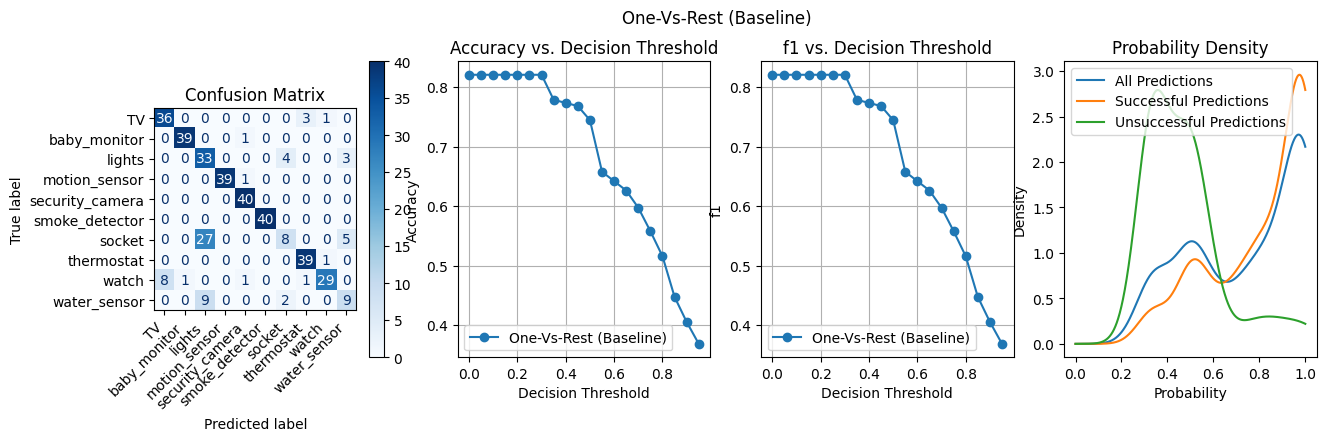

                 precision    recall  f1-score   support

             TV       0.82      0.90      0.86        40
   baby_monitor       0.97      0.97      0.97        40
         lights       0.48      0.82      0.61        40
  motion_sensor       1.00      0.97      0.99        40
security_camera       0.93      1.00      0.96        40
 smoke_detector       1.00      1.00      1.00        40
         socket       0.57      0.20      0.30        40
     thermostat       0.91      0.97      0.94        40
          watch       0.94      0.72      0.82        40
   water_sensor       0.53      0.45      0.49        20

       accuracy                           0.82       380
      macro avg       0.81      0.80      0.79       380
   weighted avg       0.83      0.82      0.81       380



In [125]:
selected_models[baseline_model_name] = baseline_pipeline
(baseline_y_pred_classes, baseline_y_pred_proba, baseline_class_labels) = get_onevsrest_predictions(selected_models[baseline_model_name], X_val)

create_classification_model_display(
    baseline_model_name,
    y_val,
    baseline_y_pred_classes,
    baseline_y_pred_proba,
    baseline_class_labels)

## OneVsRestClassifier

In [126]:
logistic_regression = LogisticRegression(class_weight='balanced', random_state=random_state, max_iter=1000)
ovr_classifier = OneVsRestClassifier(logistic_regression)
ovr_pipeline = get_pipeline(ovr_classifier, X_train)

In [127]:
# params = {
#     'classifier__estimator__C': [0.1, 1, 10],
#     'classifier__estimator__penalty': ['l1', 'l2', 'elasticnet'],
#     'classifier__estimator__solver': ['liblinear'],
#     'classifier__estimator__max_iter': [15000],
#     'classifier__estimator__random_state': [random_state],
#     'classifier__estimator__class_weight': ['balanced'],
#     'classifier__estimator__n_jobs': [-1],
#     #'classifier__estimator__l1_ratio': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
#     'classifier__estimator__l1_ratio': [0.1, 0.5, 0.9],
#     'classifier__estimator__tol': [0.001, 0.1],
#     # 'classifier__estimator__tol': [0.0001, 0.001, 0.01, 0.1],
#     'classifier__estimator__class_weight': ['balanced'],
#     'classifier__estimator__max_iter': [15000],
#     'classifier__estimator__random_state': [random_state],
#     'classifier__estimator__class_weight': ['balanced'],
# }

# best estimator
params = {
    'classifier__estimator__C': [10],
    'classifier__estimator__class_weight': ['balanced'],
    'classifier__estimator__max_iter': [15000],
    'classifier__estimator__penalty': ['l1'],
    'classifier__estimator__random_state': [random_state],
    'classifier__estimator__solver': ['liblinear'],
    'classifier__estimator__tol': [0.001],
}

start = time.time()
ovr_grid_search = GridSearchCV(ovr_pipeline, params, cv=5, scoring='accuracy')
ovr_grid_search.fit(X_train, y_train)
end = time.time()

print(f"best params: {ovr_grid_search.best_params_}")
print(f"Elapsed time: {end - start:.4f} seconds")

best params: {'classifier__estimator__C': 10, 'classifier__estimator__class_weight': 'balanced', 'classifier__estimator__max_iter': 15000, 'classifier__estimator__penalty': 'l1', 'classifier__estimator__random_state': 42, 'classifier__estimator__solver': 'liblinear', 'classifier__estimator__tol': 0.001}
Elapsed time: 5.4057 seconds


{'classifier__estimator__C': 10, 'classifier__estimator__class_weight': 'balanced', 'classifier__estimator__max_iter': 15000, 'classifier__estimator__penalty': 'l1', 'classifier__estimator__random_state': 42, 'classifier__estimator__solver': 'liblinear', 'classifier__estimator__tol': 0.001}


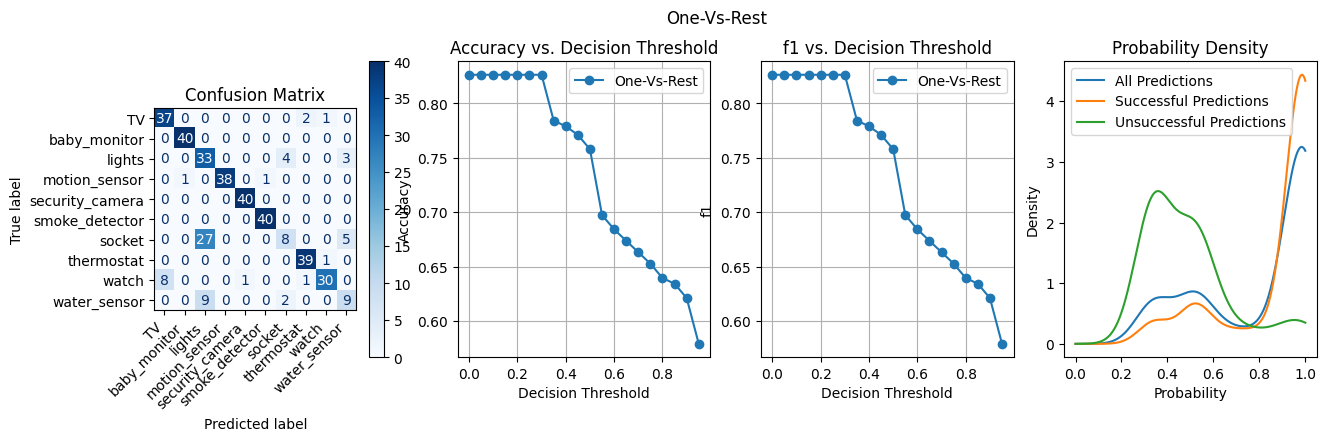

                 precision    recall  f1-score   support

             TV       0.82      0.93      0.87        40
   baby_monitor       0.98      1.00      0.99        40
         lights       0.48      0.82      0.61        40
  motion_sensor       1.00      0.95      0.97        40
security_camera       0.98      1.00      0.99        40
 smoke_detector       0.98      1.00      0.99        40
         socket       0.57      0.20      0.30        40
     thermostat       0.93      0.97      0.95        40
          watch       0.94      0.75      0.83        40
   water_sensor       0.53      0.45      0.49        20

       accuracy                           0.83       380
      macro avg       0.82      0.81      0.80       380
   weighted avg       0.83      0.83      0.81       380



In [128]:
selected_models[ovr_model_name] = ovr_grid_search
print(ovr_grid_search.best_params_)

(ovr_y_pred_classes, ovr_y_pred_proba, ovr_class_labels) = get_onevsrest_predictions(selected_models[ovr_model_name], X_val)

create_classification_model_display(
    ovr_model_name,
    y_val,
    ovr_y_pred_classes,
    ovr_y_pred_proba,
    ovr_class_labels)

## Random Forest

In [129]:
random_forest_classifier = RandomForestClassifier()
random_forest_pipeline = get_pipeline(random_forest_classifier, X_train)

In [130]:
# params = {
#     'classifier__n_estimators': [200, 300],
#     'classifier__max_features': [None],
#     'classifier__max_depth': [6, 7, 8],
#     'classifier__random_state': [random_state],
#     'classifier__class_weight': ['balanced'],
#     'classifier__n_jobs': [-1],
#     'classifier__criterion': ['gini', 'entropy', 'log_loss'],
#     'classifier__min_samples_split': [2],
#     'classifier__min_samples_leaf': [1],
#     'classifier__min_weight_fraction_leaf': [0.0],
#     'classifier__max_leaf_nodes': [None],
#     'classifier__min_impurity_decrease': [0.0],
#     'classifier__bootstrap': [True],
#     'classifier__oob_score': [False],
#     'classifier__warm_start': [False],
#     'classifier__class_weight': [None],
#     'classifier__ccp_alpha': [0.0],
#     'classifier__max_samples': [None],
# }

# best estimator
params = {
   'classifier__bootstrap': [True],
   'classifier__class_weight': [None],
   'classifier__criterion': ['entropy'],
   'classifier__max_depth': [8],
   'classifier__max_features': [None],
   'classifier__max_leaf_nodes': [None],
   'classifier__max_samples': [None],
   'classifier__min_impurity_decrease': [0.0],
   'classifier__min_samples_leaf': [1],
   'classifier__min_samples_split': [2],
   'classifier__min_weight_fraction_leaf': [0.0],
   'classifier__n_estimators': [200],
   'classifier__n_jobs': [-1],
   'classifier__oob_score': [False],
   'classifier__random_state': [random_state],
   'classifier__warm_start': [False],
   }

start = time.time()
rf_grid_search = GridSearchCV(random_forest_pipeline, params, cv=5, scoring='accuracy')
rf_grid_search.fit(X_train, y_train)
end = time.time()

print(f"best params: {rf_grid_search.best_params_}")
print(f"Elapsed time: {end - start:.4f} seconds")

best params: {'classifier__bootstrap': True, 'classifier__class_weight': None, 'classifier__criterion': 'entropy', 'classifier__max_depth': 8, 'classifier__max_features': None, 'classifier__max_leaf_nodes': None, 'classifier__max_samples': None, 'classifier__min_impurity_decrease': 0.0, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2, 'classifier__min_weight_fraction_leaf': 0.0, 'classifier__n_estimators': 200, 'classifier__n_jobs': -1, 'classifier__oob_score': False, 'classifier__random_state': 42, 'classifier__warm_start': False}
Elapsed time: 44.7760 seconds


{'classifier__bootstrap': True, 'classifier__class_weight': None, 'classifier__criterion': 'entropy', 'classifier__max_depth': 8, 'classifier__max_features': None, 'classifier__max_leaf_nodes': None, 'classifier__max_samples': None, 'classifier__min_impurity_decrease': 0.0, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2, 'classifier__min_weight_fraction_leaf': 0.0, 'classifier__n_estimators': 200, 'classifier__n_jobs': -1, 'classifier__oob_score': False, 'classifier__random_state': 42, 'classifier__warm_start': False}


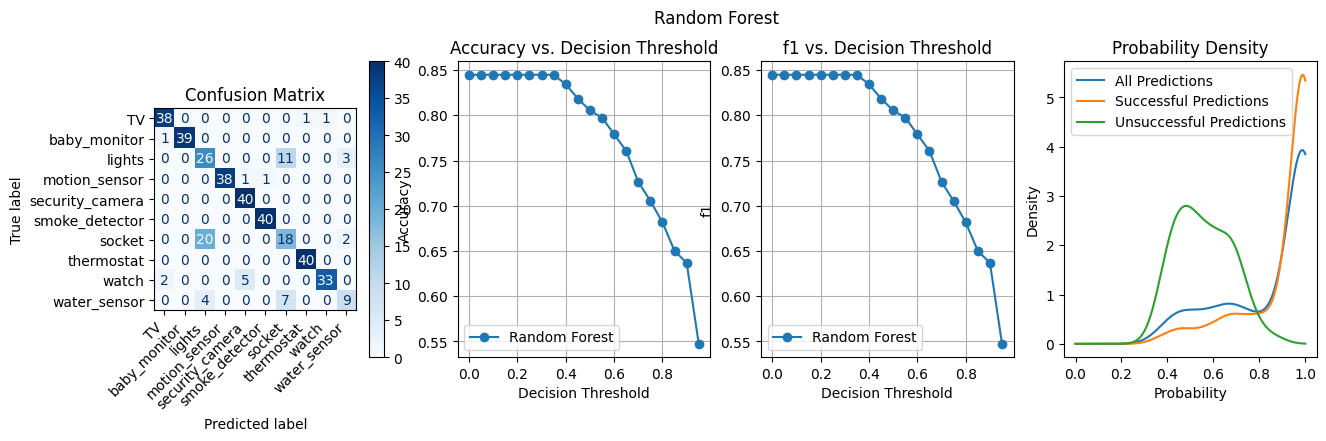

                 precision    recall  f1-score   support

             TV       0.93      0.95      0.94        40
   baby_monitor       1.00      0.97      0.99        40
         lights       0.52      0.65      0.58        40
  motion_sensor       1.00      0.95      0.97        40
security_camera       0.87      1.00      0.93        40
 smoke_detector       0.98      1.00      0.99        40
         socket       0.50      0.45      0.47        40
     thermostat       0.98      1.00      0.99        40
          watch       0.97      0.82      0.89        40
   water_sensor       0.64      0.45      0.53        20

       accuracy                           0.84       380
      macro avg       0.84      0.82      0.83       380
   weighted avg       0.85      0.84      0.84       380



In [131]:
best_rf_model = rf_grid_search
selected_models[random_forest_model_name] = rf_grid_search
print(rf_grid_search.best_params_)

(rf_y_pred_classes, rf_y_pred_proba, rf_class_labels) = get_randomforest_predictions(selected_models[random_forest_model_name], X_val)

create_classification_model_display(
    random_forest_model_name,
    y_val,
    rf_y_pred_classes,
    rf_y_pred_proba,
    rf_class_labels)

## XGBoost

In [132]:
# setting 'verbosity=0' to avoid getting nuisance warnings in the output
xgboost_classifier = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=random_state, verbosity=0)
xgboost_pipeline = get_pipeline(xgboost_classifier, X_train)

In [133]:
# params = {
#     'classifier__n_estimators': [100, 200, 300],
#     'classifier__max_depth': [6, 7, 8],
#     'classifier__learning_rate': [0.1],
# }

# best estimator
params = {
    'classifier__n_estimators': [300],
    'classifier__max_depth': [6],
    'classifier__learning_rate': [0.1],
}

start = time.time()
xgboost_gridsearch = GridSearchCV(xgboost_pipeline, params, cv=5, scoring='accuracy')

xgb_label_encoder = LabelEncoder()
y_train_encoded = xgb_label_encoder.fit_transform(y_train)

xgboost_gridsearch.fit(X_train, y_train_encoded)
end = time.time()

print(f"best params: {xgboost_gridsearch.best_params_}")
print(f"Elapsed time: {end - start:.4f} seconds")

best params: {'classifier__learning_rate': 0.1, 'classifier__max_depth': 6, 'classifier__n_estimators': 300}
Elapsed time: 47.4756 seconds


{'classifier__learning_rate': 0.1, 'classifier__max_depth': 6, 'classifier__n_estimators': 300}


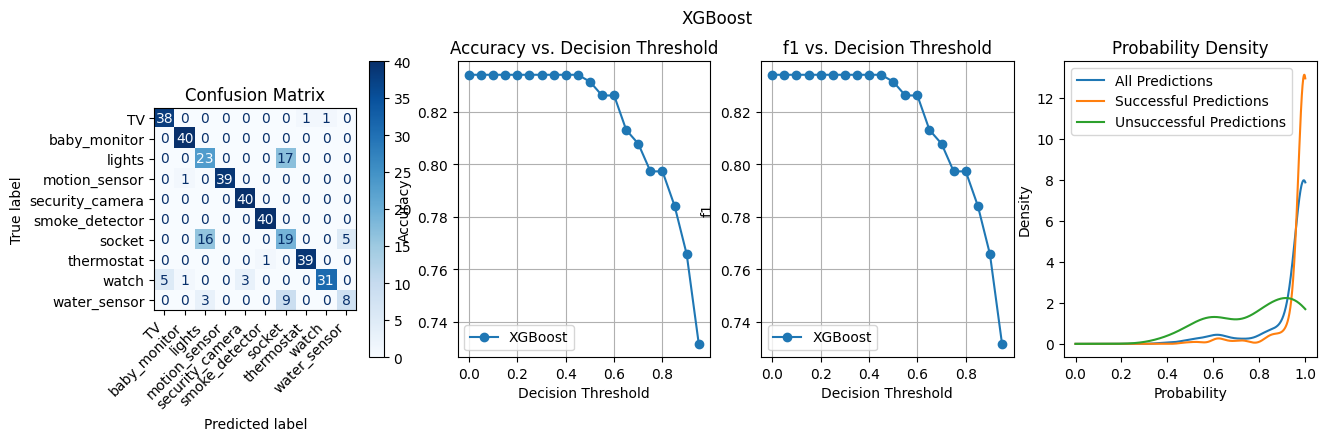

                 precision    recall  f1-score   support

             TV       0.88      0.95      0.92        40
   baby_monitor       0.95      1.00      0.98        40
         lights       0.55      0.57      0.56        40
  motion_sensor       1.00      0.97      0.99        40
security_camera       0.93      1.00      0.96        40
 smoke_detector       0.98      1.00      0.99        40
         socket       0.42      0.47      0.45        40
     thermostat       0.97      0.97      0.97        40
          watch       0.97      0.78      0.86        40
   water_sensor       0.62      0.40      0.48        20

       accuracy                           0.83       380
      macro avg       0.83      0.81      0.82       380
   weighted avg       0.84      0.83      0.83       380



In [134]:
selected_models[xgboost_model_name] = xgboost_gridsearch
print(xgboost_gridsearch.best_params_)

(xgb_y_pred_classes, xgb_y_pred_proba, xgb_class_labels) = get_xgboost_predictions(selected_models[xgboost_model_name], X_val, xgb_label_encoder)

create_classification_model_display(
    xgboost_model_name,
    y_val,
    xgb_y_pred_classes,
    xgb_y_pred_proba,
    xgb_class_labels)

## Neural Network

In [135]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from tensorflow.keras.optimizers import Adam
from tensorflow import keras
from tensorflow.keras import layers
from imblearn.over_sampling import SMOTE

# Label encode
nn_label_encoder = LabelEncoder()
y_train_encoded = nn_label_encoder.fit_transform(y_train)
y_value_encoded = nn_label_encoder.transform(y_val)
y_test_encoded = nn_label_encoder.transform(y_test)

num_classes = len(nn_label_encoder.classes_)

# Scale features
scaler = get_preprocessing_pipeline(X_train)
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Apply SMOTE to oversample the training data
sampling_strategy = {
    2: 400,  # Increase class 2 (lights) to 400 samples
    6: 400,  # Increase class 6 (socket) to 400 samples
    9: 400   # Increase class 9 (water_sensor) to 400 samples
}

smote = SMOTE(sampling_strategy=sampling_strategy, random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train_encoded)

# Define the model
neural_network_model = keras.Sequential([
    layers.Input(shape=(X_train.shape[1],)),
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(num_classes, activation='softmax')
])

optimizer = Adam(learning_rate=0.0005)

early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=15,
    restore_best_weights=True
)

neural_network_model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the model using SMOTE-augmented data
neural_network_model.fit(X_train_resampled, y_train_resampled,
          validation_data=(X_test_scaled, y_test_encoded),
          epochs=75,
          batch_size=32,
          callbacks=[early_stopping]
          )

Epoch 1/75
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.3135 - loss: 1.9632 - val_accuracy: 0.5789 - val_loss: 1.8216
Epoch 2/75
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5625 - loss: 1.1270 - val_accuracy: 0.7342 - val_loss: 1.5085
Epoch 3/75
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6154 - loss: 0.9376 - val_accuracy: 0.7447 - val_loss: 1.4825
Epoch 4/75
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6633 - loss: 0.8390 - val_accuracy: 0.7658 - val_loss: 1.4362
Epoch 5/75
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6593 - loss: 0.7655 - val_accuracy: 0.7711 - val_loss: 1.4543
Epoch 6/75
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6916 - loss: 0.7115 - val_accuracy: 0.7947 - val_loss: 1.5213
Epoch 7/75
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7131 - loss: 0.6487 - val_accuracy: 0.8000 - val_loss: 1.5099
Epoch 8/75
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7136 - loss: 0.6323 - val_accuracy: 0.8079 - val_loss

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


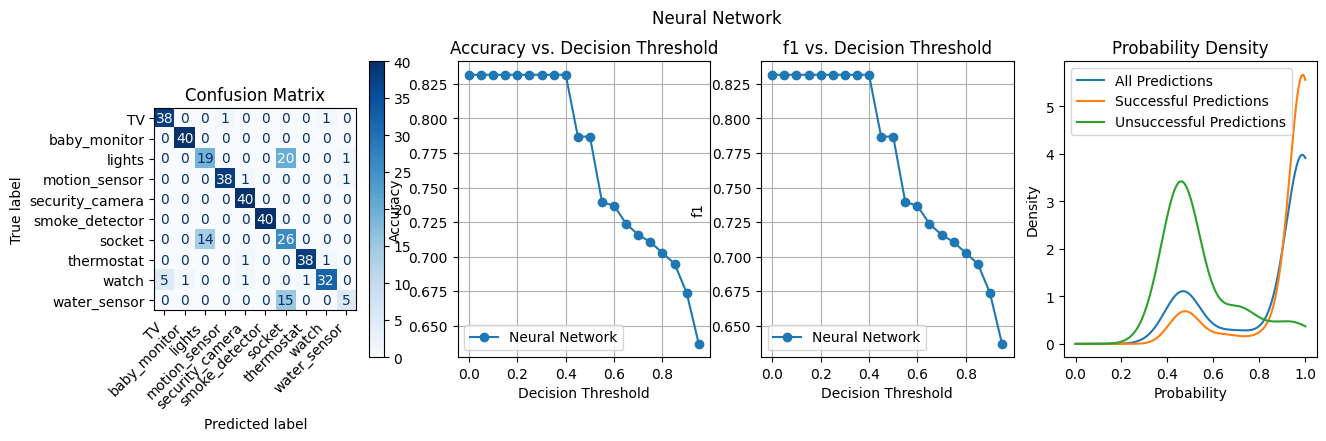

                 precision    recall  f1-score   support

             TV       0.88      0.95      0.92        40
   baby_monitor       0.98      1.00      0.99        40
         lights       0.58      0.47      0.52        40
  motion_sensor       0.97      0.95      0.96        40
security_camera       0.93      1.00      0.96        40
 smoke_detector       1.00      1.00      1.00        40
         socket       0.43      0.65      0.51        40
     thermostat       0.97      0.95      0.96        40
          watch       0.94      0.80      0.86        40
   water_sensor       0.71      0.25      0.37        20

       accuracy                           0.83       380
      macro avg       0.84      0.80      0.81       380
   weighted avg       0.85      0.83      0.83       380



In [136]:
selected_models[neural_network_model_name] = neural_network_model

## use the scikit learn preprocessing to scale the input data the
X_val_scaled = scaler.transform(X_val)

(nn_y_pred_classes, nn_y_pred_proba, nn_class_labels) = get_softmax_predictions(selected_models[neural_network_model_name], X_val_scaled, nn_label_encoder)

create_classification_model_display(
    neural_network_model_name,
    y_val,
    nn_y_pred_classes,
    nn_y_pred_proba,
    nn_class_labels)

## Results

In [137]:
# preprocessing_pipeline = get_preprocessing_pipeline(X_train)
## use the scikit learn preprocessing to scale the input data the
## use the scaler created in the neural network training for the neural network to make predictions
all_model_predictions_val = get_all_model_predictions(X_val, xgb_label_encoder, nn_label_encoder, scaler)
all_model_predictions_test = get_all_model_predictions(X_test, xgb_label_encoder, nn_label_encoder, scaler)

label_encoder = LabelEncoder()
label_encoder.fit_transform(y_train)
class_labels = label_encoder.classes_

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


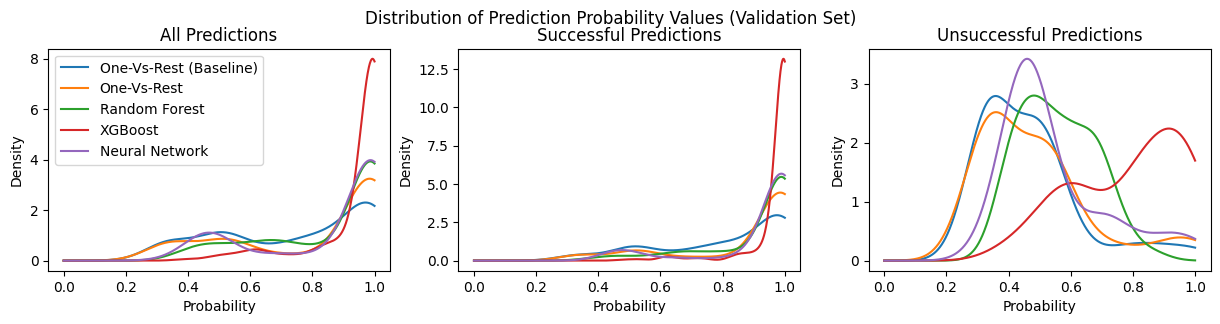

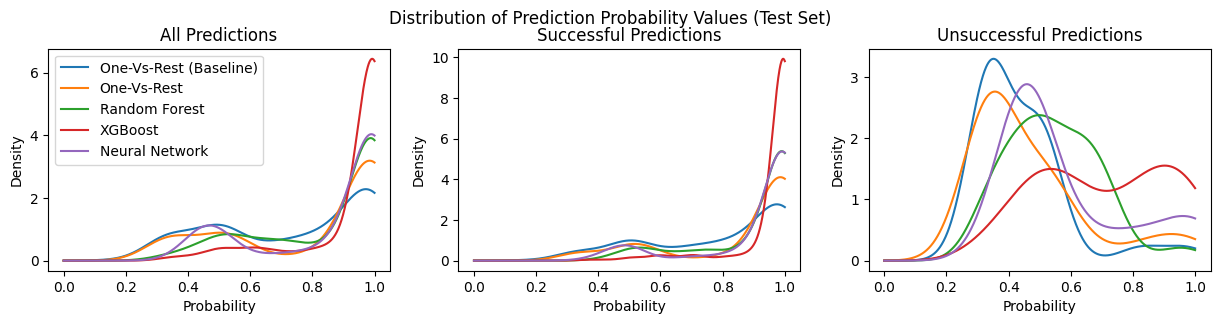

In [138]:
create_composite_probabilities_display(all_model_predictions_val, y_val, 'Distribution of Prediction Probability Values (Validation Set)')
create_composite_probabilities_display(all_model_predictions_test, y_test, 'Distribution of Prediction Probability Values (Test Set)')

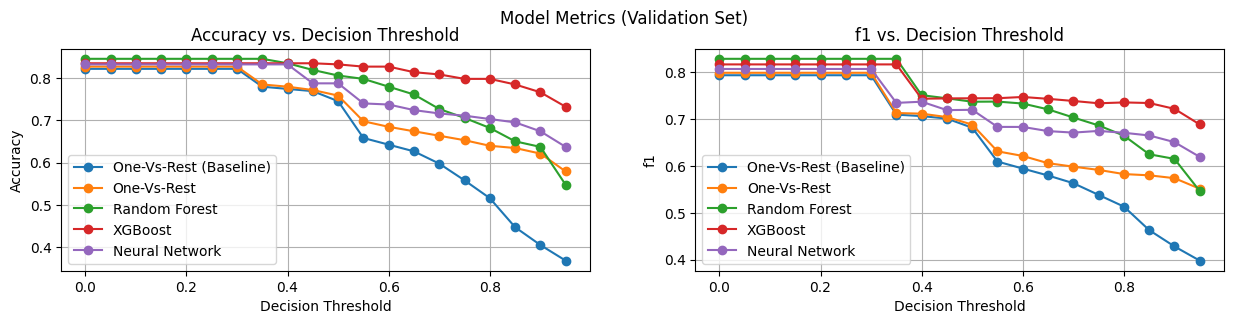

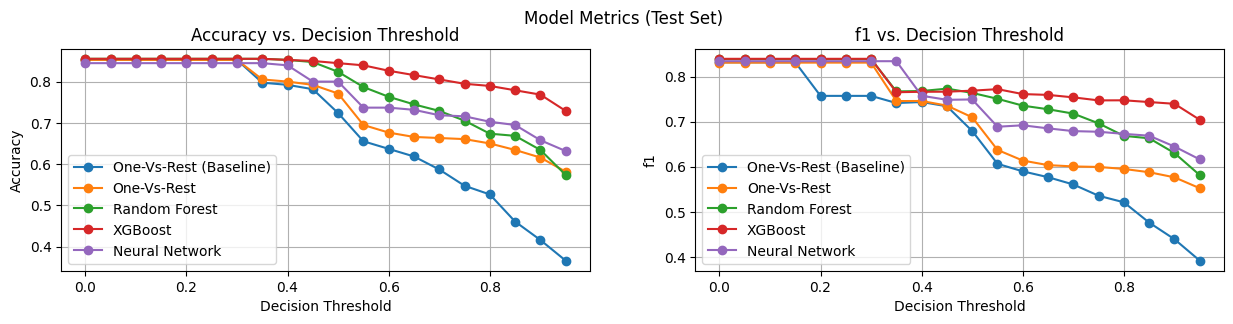

In [139]:
create_composite_metrics_display2(all_model_predictions_val, y_val, class_labels, 'Model Metrics (Validation Set)')
create_composite_metrics_display2(all_model_predictions_test, y_test, class_labels, 'Model Metrics (Test Set)')

In [140]:
val_metrics_report = get_metrics_report(all_model_predictions_val, y_val, class_labels)
test_metrics_report = get_metrics_report(all_model_predictions_test, y_test, class_labels)

print_metrics_report(val_metrics_report)
print_metrics_report(test_metrics_report)

| Model | Accuracy | Precision | Recall | f1 |
|---|---|---|---|---|
| One-Vs-Rest (Baseline) | 0.821 | 0.814 | 0.802 | 0.793 |
| One-Vs-Rest | 0.826 | 0.819 | 0.807 | 0.798 |
| Random Forest | 0.845 | 0.838 | 0.825 | 0.828 |
| XGBoost | 0.834 | 0.827 | 0.812 | 0.816 |
| Neural Network | 0.832 | 0.840 | 0.802 | 0.806 |
| Model | Accuracy | Precision | Recall | f1 |
|---|---|---|---|---|
| One-Vs-Rest (Baseline) | 0.855 | 0.869 | 0.847 | 0.834 |
| One-Vs-Rest | 0.855 | 0.868 | 0.847 | 0.833 |
| Random Forest | 0.855 | 0.846 | 0.843 | 0.839 |
| XGBoost | 0.855 | 0.839 | 0.843 | 0.839 |
| Neural Network | 0.845 | 0.859 | 0.827 | 0.834 |


**Validation Set Metrics**

| Model | Accuracy | Precision | Recall | f1 |
|---|---|---|---|---|
| One-Vs-Rest (Baseline) | 0.821 | 0.814 | 0.802 | 0.793 |
| One-Vs-Rest | 0.826 | 0.819 | 0.807 | 0.798 |
| Random Forest | 0.845 | 0.838 | 0.825 | 0.828 |
| XGBoost | 0.834 | 0.827 | 0.812 | 0.816 |
| Neural Network | 0.832 | 0.840 | 0.802 | 0.806 |

**Test Set Metrics**

| Model | Accuracy | Precision | Recall | f1 |
|---|---|---|---|---|
| One-Vs-Rest (Baseline) | 0.855 | 0.869 | 0.847 | 0.834 |
| One-Vs-Rest | 0.855 | 0.868 | 0.847 | 0.833 |
| Random Forest | 0.855 | 0.846 | 0.843 | 0.839 |
| XGBoost | 0.855 | 0.839 | 0.843 | 0.839 |
| Neural Network | 0.845 | 0.859 | 0.827 | 0.834 |

In [141]:
def print_results(all_predictions, y_actual, labels):
  y_pred = {}
  y_prob = {}

  for model_name in all_predictions:
    y_pred[model_name] = all_predictions[model_name][y_pred_classes_result]
    y_prob[model_name] = all_predictions[model_name][y_pred_proba_result]

    print(f'{model_name}:')
    print(confusion_matrix(y_actual, y_pred[model_name]))
    print(f'accuracy: {accuracy_score(y_actual, y_pred[model_name])}')

    mask = y_pred[model_name] == y_actual
    correct_predictions = y_pred[model_name][mask]
    print(f'correct predictions: {len(correct_predictions)}')
    print()

In [142]:
# sanity check to verify that all models have the same accuracy is not an error.
# all models each correctly predicted 325 samples from the test set, however the confusion matrices show a slightly different selection.
print_results(all_model_predictions_test, y_test, class_labels)

One-Vs-Rest (Baseline):
[[34  1  0  0  1  0  0  1  3  0]
 [ 0 40  0  0  0  0  0  0  0  0]
 [ 0  0 37  0  0  0  1  0  0  2]
 [ 0  0  0 39  0  0  0  0  0  1]
 [ 0  0  0  0 40  0  0  0  0  0]
 [ 0  0  0  1  0 39  0  0  0  0]
 [ 0  0 24  0  0  0 10  0  0  6]
 [ 2  0  0  0  0  0  0 37  1  0]
 [ 2  1  0  0  1  0  0  1 35  0]
 [ 0  0  6  0  0  0  0  0  0 14]]
accuracy: 0.8552631578947368
correct predictions: 325

One-Vs-Rest:
[[36  1  0  1  1  0  0  0  0  1]
 [ 0 40  0  0  0  0  0  0  0  0]
 [ 0  0 35  0  0  0  1  0  0  4]
 [ 0  1  0 37  0  0  0  0  1  1]
 [ 0  0  0  0 40  0  0  0  0  0]
 [ 0  0  0  1  0 39  0  0  0  0]
 [ 0  0 23  0  0  0 10  0  0  7]
 [ 2  0  0  0  0  0  0 37  1  0]
 [ 1  2  0  0  0  0  0  0 37  0]
 [ 0  0  6  0  0  0  0  0  0 14]]
accuracy: 0.8552631578947368
correct predictions: 325

Random Forest:
[[37  0  0  1  2  0  0  0  0  0]
 [ 0 40  0  0  0  0  0  0  0  0]
 [ 0  0 33  0  0  0  5  0  0  2]
 [ 0  0  0 37  1  0  0  1  0  1]
 [ 0  0  0  0 36  0  0  4  0  0]
 [ 0  0  0 

In [143]:
# Remove smoke_detector classes from original dataset as use it as an example of an unknown IoT device
smoke_detector_samples = merged_df[merged_df['device_category'] == 'smoke_detector']
iot_samples = merged_df[merged_df['device_category'] != 'smoke_detector']

smoke_detector_X = smoke_detector_samples.drop(columns=['device_category'])
smoke_detector_y = smoke_detector_samples['device_category']

X = iot_samples.drop(columns=['device_category'])
y = iot_samples['device_category']

In [144]:
# Train a new instance of XGBoost without smoke detectors
xgboost_classifier = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=random_state, verbosity=0)
new_xgboost_pipeline = get_pipeline(xgboost_classifier, X)

params = {
    'classifier__n_estimators': [300],
    'classifier__max_depth': [6],
    'classifier__learning_rate': [0.1],
}

new_xgboost_gridsearch = GridSearchCV(new_xgboost_pipeline, params, cv=5, scoring='accuracy')

new_xgb_label_encoder = LabelEncoder()
y_encoded = xgb_label_encoder.fit_transform(y)

new_xgboost_gridsearch.fit(X, y_encoded)


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(transformers=[('numeric',
                                                                         Pipeline(steps=[('variance_filter',
                                                                                          VarianceThreshold()),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         Index(['ack', 'ack_A', 'ack_B', 'bytes', 'bytes_A', 'bytes_A_B_ratio',
       'bytes_B', 'ds_field_B', 'duration', 'http_bytes_avg',
       ...
       'ttl_avg', 'ttl_entropy', 'ttl_firstQ', 'ttl...
                                                      max_cat_to_onehot=None,
                                                      max_delta_step=None,
                                                      max_depth=None,
                                                      max_leaves=None,
                                                      min_child_weight=None,
                                                      missing=nan,
                                                      monotone_constraints=None,
                                                      multi_strategy=None,
                                                      n_estimators=None,
                                                      n_jobs=None,
                                                      num_parallel_tree=None,
                                                      random_state=42, ...))]),
             param_grid={'classifier__learning_rate': [0.1],
                         'classifier__max_depth': [6],
                         'classifier__n_estimators': [300]},
             scoring='accuracy')

motion_sensor: 3
thermostat: 10
watch: 186
water_sensor: 1


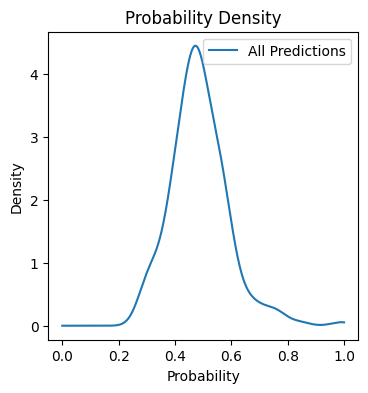

In [145]:
new_xgboost_model = new_xgboost_gridsearch

(sd_xgb_y_pred_classes, sd_xgb_y_pred_proba, sd_xgb_class_labels) = get_xgboost_predictions(new_xgboost_model, smoke_detector_X, xgb_label_encoder)

all_probabilities = sd_xgb_y_pred_proba.max(axis=1)

kde_all = gaussian_kde(all_probabilities)

# Define evaluation points (support)
x = np.linspace(0, 1, 1000)

density_all = kde_all(x)
fig, axis = plt.subplots(1, 1, figsize=(4, 4)) # rows, columns, (width, height)
axis.plot(x, density_all, label='All Predictions')
axis.set_xlabel('Probability')
axis.set_ylabel('Density')
axis.set_title(f'Probability Density')
axis.legend()

# list out the predicted classes
unique_classes, counts = np.unique(sd_xgb_y_pred_classes, return_counts=True)
for class_name, count in zip(unique_classes, counts):
    print(f"{class_name}: {count}")

# Conclusion
The OneVsRest, Random Forest, XGBoost classifiers all tied for the highest accuracy (0.855) and the OneVsRest (Baseline) achieved the highset precision (0.869). Both OneVsRest classifiers tied for the highest recall (0.847). The highest f1 scores were achieved by the Random Forest and XGBoost classifiers (0.839). This performance contrasts with the validation set results, where the Random Forest classifier performed best overall, with an accuracy of 0.845, precision of 0.838, recall of 0.825, and F1 score of 0.828. Interestingly, the test set metrics were slightly higher than those from the validation set—an unexpected outcome that suggests either random variation or possible differences in sample composition.

Several models produced identical accuracy values on the test set. To ensure these results were valid, confusion matrices were examined, and the number of correct predictions was tallied. Even though some models had the same number of correct predictions (325), the distribution of those predictions varied across classes, indicating differing classification behavior despite identical accuracy.

A recurring challenge for all models was accurately identifying the lights, socket, and water_sensor IoT device classes. Even after applying SMOTE oversampling to address class imbalance, the neural network showed no substantial improvement in classifying these three device types. LASSO feature selection revealed that these classes had the fewest distinguishing features, which likely contributed to their classification difficulty.

One objective of this project was to explore whether it is possible to distinguish unseen (untrained) IoT device types using the probability scores returned by predict_proba(). For most classifiers, successful predictions typically had a maximum class probability above 0.85, while unsuccessful predictions often fell between 0.2 and 0.8. However, both XGBoost and the neural network occasionally returned incorrect predictions with high confidence (probabilities above 0.8). Although there was a noticeable drop in successful predictions below a probability threshold of 0.85, a significant number of correct predictions still occurred below this threshold. As a result, no clear cutoff probability emerged for reliably detecting unseen classes.

To investigate this further, an XGBoost model was trained on all device classes except for the smoke_detector, which was treated as an unseen class. When tested on the excluded smoke_detector samples, the classifier predicted most of them as a watch (186 samples), with the remaining 14 samples distributed among motion_sensor, thermostat, and water_sensor. The predict_proba() values for these predictions formed a roughly normal distribution centered around 0.5, suggesting that untrained (unseen) samples yield outputs that resemble random classification behavior.